# Lab 9: Facial Recognition with Eigenfaces

![Eigenfaces](https://github.com/tonyscan6003/etivities/blob/main/eigenfaces.JPG?raw=true)

In this lab assignment we will obtain eigenfaces from a small dataset of faces.
We will demonstrate reconstraction of faces with the eigenfaces.
We will train a Support Vector Machine Classifier and demonstrate facial recognition. (The dataset used ["Olivetti Faces"](https://scikit-learn.org/stable/datasets/index.html#real-world-datasets)  contains 40 people with 10 examples for each face. )


Your Task is to create the class `EigenfaceRecogniser`. The class will contain methods to compute the eigenfaces `compute_eigenfaces` of the training data `X_train`, and secondly transform the training data using K eigenvectors and reconstruct the faces `compress_and_reconstruct`. Additionally the `train_classifier` method will train a support vector machine classifier on `X_train` and test the classification on the `X_test` data using the `test_classifier` mehtod. The notes below give details on creating these methods using matrix operations, AI generated code may use PCA packages/methods to perform the same function.

The operation of your class can be verified in the Evaluation cells, there are additional methods from the `DatasetPlotting` class in this notebook that plot:
* The top 30 Eigenfaces (from Computed Eigenvector Matrix)
* Original images and Reconstructed Faces for K = 30 Eigenfaces
* A classification report from the classifier and plot showing test examples indicating if the correct label was applied.

**Method 1: `compute_eigenfaces`**
As we saw in the Video lesson on Eigenfaces we use Principle Component Analysis to obtain eigenvectors. In this method we will find the sample covariance matrix from the data and obtain the eigenvectors and eigenvalues.

1. Given an array of samples $X$, We first must obtain the mean of values of the features, across all the datasamples. This will be a vector $ \mu = \frac{1}{n}\sum_{i=1}^{n} x_i$.
2. We sutract the mean values from the array of samples giving the mean corrected array of samples $X_c=X-\mu$
3.  The sample covariance matrix $\Sigma$ is produced by the matrix product of the mean corrected array and it's transpose $\Sigma=X_cX_c^T$.
4. The Eigenvectors $V$ and Eigenvalues $L$ of the sample covariance matrix are found.
5. The eigenfaces corresponding to the largest Eigenvalues are obtained by reshaping the corresponding Eigenvector and displaying as an image.

Hints:
>The input data is in the form n_features x n_samples. (Ensure the mean is calculated along the correct dimesion or the array)

> When performing subraction of the mean value vector from the array of samples, the [numpy broadcasting rules](https://numpy.org/doc/stable/user/basics.broadcasting.html) will apply.

> Matrix multiplication may be performed with [numpy matmul](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html), using * will perform [element wise multiplication](https://numpy.org/doc/stable/reference/generated/numpy.multiply.html) of two arrays.

>Use the [numpy eigenvalue solver](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html) to obtain the eigvalues and eigenvectors of the sample covariance matrix.  

> [Numpy Mean](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) and [Numpy Transpose](https://numpy.org/doc/stable/reference/generated/numpy.transpose.html) may be useful.



**Method 2: `compress_and_reconstruct`**.
 The database of faces can be transformed into it's eigenface representation and reconstructed back to an image. Rather than using all eigenface vectors, You can use a reduced number of eigenfaces `n_eigenfaces`.

  > You can investigate the quality of the face reconstruction by varying `n_eigenfaces`. The idea of doing this is to see what is a good minimum number of Eigenfaces we need to properly represent the faces.

1. We can perform the transformation of the database of faces by maxtrix multiplation with the transpose of the k Eigenvectors $T_k=V_k^TX_c$.   

2. The reconstructed database $X_c^k$ is obtained by matrix multiplication of the transformed database with the k Eigenvectors $X_c^k=V_kT_k$.

3. In the evaluation cell you can use the method `plot_reconstructions` to plot some pairs of original faces from the dataset and the reconstructed faces. (This allows us to observe the quality of reconstruction with the variation in the number of eigenfaces used for the representation.)

> Note that the average $\mu$ needs to be added back to the reconstracted face to display properly.

**Method 3/4: `train_classifier` and `test_classifier`**
Now that we have selected the appropriate value of number eigenfaces to represent our database, we can now perform recognition between the test set and training set. The key steps we need to carry out.

1. Initialise and train classifier on X_train (just remember to train on the transformed data)
2. Transform Test data `X_test` before applying to classifier.
3. Obtain predictions from test set `X_test` & get a [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)


Hints:
> The test data (after subtraction of mean $\mu$ must also be transformed by matrix multiplication with the set of k eigenvectors in order to be used for prediction.

>As there are multiple (10) images for each person in this dataset, it is possible to use a range of classifiers (e.g. KNN, SVM) on the transformed data.

>The [sklearn classifiers](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) are simple to setup and suitable use for this application.

>For sklearn is important to note that the input to the classifier must be in the form *n_samples x n_features*. Therefore the Transformed data may need to be transposed in order to train/test the classifier.



#HouseKeeping:
Import Packages

In [11]:
from sklearn import datasets
from skimage import feature
from skimage import exposure
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import decomposition
import numpy as np
import urllib
import cv2
import pickle
import matplotlib.pyplot as plt

 # Load & display the Olivetti Faces
 This dataset consists of 400 faces of size 64 x 64 = 4096 pixels. (This is a sklearn built in dataset and is very simple to load) As the number of pixels is very large we need to use eignfaces to produce a representation in a more compact form, that we can use for matching/classification.

We will divide the the dataset in train and test splits.

>Note that the labels are also supplied in the sklearn dataset that we loaded.

>We transpose the original data so it is in the form *n_features x n_samples*. This is consistent with the form used in the lecture notes. The features are the 4096 pixels from the images.

> This class also contains several plotting methods that we use in evalutation to check the methods in our class.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

class DatasetPlotting:
    def __init__(self, test_size=0.25, random_state=0):
        # On intialisation load dataset to instance variables
        self.test_size = test_size
        self.random_state = random_state
        self.faces = datasets.fetch_olivetti_faces(data_home=".")
        self.image_shape = (64, 64)
        self._prepare_data()


    def _prepare_data(self):
        X_train, X_test, y_train, y_test = train_test_split(
            self.faces.data, self.faces.target,
            test_size=self.test_size,
            random_state=self.random_state
        )
        self.X_train = X_train.T  # Transpose to shape (features, samples)
        self.X_test = X_test.T
        self.y_train = y_train
        self.y_test = y_test
        self.image_shape = [int(np.sqrt(len(self.X_train))),int(np.sqrt(len(self.X_train)))]


    def get_data(self):
        return self.X_train, self.X_test, self.y_train, self.y_test

    def plot_samples(self, n_rows=2, n_cols=5):
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(1.5 * n_cols, 2 * n_rows))
        for i, ax in enumerate(axes.flat):
            ax.imshow(self.faces.images[i], cmap='gray')
            ax.set_title(f"ID: {self.faces.target[i]}")
            ax.axis('off')
        plt.tight_layout()
        plt.show()

    def plot_eigenfaces(self, V, n_faces=30):
        '''
         Inputs:
           V - Eigenfaces vector
           n_faces - Number of faces to plot
         '''
        fig = plt.figure(figsize=(16, 6))
        for i in range(n_faces):
            ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
            ax.imshow(V[:, i].reshape(self.image_shape), cmap=plt.cm.bone)
        plt.suptitle("Top Eigenfaces")
        plt.show()

    def plot_reconstructions(self, X_train, X_recon, n_pairs=16):
        '''
          Inputs:
            X-train - Original Data
            X_recon - Reconstructed Data
            n_pairs - Number of pairs to plot
        '''
        fig = plt.figure(figsize=(2, 10))
        for i in range(n_pairs):
            ax = fig.add_subplot(8, 2, i + 1, xticks=[], yticks=[])
            if i % 2 == 0:
                ax.imshow(X_train[:, i].reshape(self.image_shape), cmap=plt.cm.bone)
            else:
                ax.imshow(X_recon[:, i-1].reshape(self.image_shape), cmap=plt.cm.bone)
        plt.suptitle("Original and Reconstructed Faces")
        plt.show()

    def plot_test_examples(self, X_test,y_test, y_pred, n_samples=100):
        '''
          Inputs:
            n_samples - Number of samples to plot
            X_test - Test Sample Images
            y_test - Ground truth labels
            y_pred - Predicted labels
        '''
        fig = plt.figure(figsize=(20, 15))
        for i in range(n_samples):
            ax = fig.add_subplot(10, 20, i + 1, xticks=[], yticks=[])
            ax.imshow(X_test[:, i].reshape(self.image_shape), cmap=plt.cm.bone)
            color = 'black' if y_pred[i] == y_test[i] else 'red'
            ax.set_title(y_test[i], fontsize='small', color=color)
        plt.suptitle("Test Set Predictions (Red = Incorrect)")
        plt.show()

Train shape: (4096, 300)
Test shape: (4096, 100)


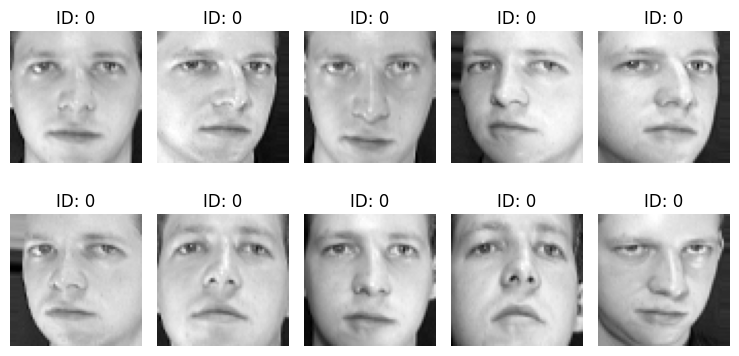

In [13]:
loader = DatasetPlotting()
X_train, X_test, y_train, y_test = loader.get_data()
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Plot sample images
loader.plot_samples()


# Create Class
In the code cell below you can complete the `EigenfaceReconizer` class, skeleton code is provided for this class and the methods, `compute_eigenfaces`, `compress_and_reconstruct`,`train_classifier` and `test_classifier`.
As the methods have limited positional arguments, and are designed to work with the plotting methods in the evaluation cell, it will be necessary for you to use instance variables to make the Eigenvalues matrix obtained using `compute_eigenfaces` available to the other methods. We note that X_train, X_test, y_train, y_test are input the class on initialisation and are also made availalble as instance variables (so these are not passed as argments during calls to the methods)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

class EigenfaceRecognizer:
    def __init__(self, X_train, X_test, y_train, y_test, image_shape=(64, 64)):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

        self.classifier = None
        self.model_path = './cls_model.pkl'



    def compute_eigenfaces(self):
        self.avg_face_vec = np.mean(self.X_train, axis=1, keepdims=True)
        centred_data = self.X_train - self.avg_face_vec
        cov_mat = centred_data @ centred_data.T
        eig_vals, eig_vecs = eig(cov_mat)
        ordering = np.argsort(eig_vals)[::-1]
        eig_vals = eig_vals[ordering]
        eig_vecs = eig_vecs[:, ordering]
        self.eig_values = eig_vals
        self.eig_vectors = eig_vecs

        return eig_vals, eig_vecs

    def compress_and_reconstruct(self, n_eigenfaces):
        centred_data = self.X_train - self.avg_face_vec
        top_components = self.eig_vectors[:, :n_eigenfaces]
        projection = top_components.T @ centred_data
        reconstruction = top_components @ projection
        reconstruction = reconstruction + self.avg_face_vec

        return reconstruction

    def train_classifier(self, method='svm', n_eigenfaces=50):
        centred_data = self.X_train - self.avg_face_vec
        top_components = self.eig_vectors[:, :n_eigenfaces]
        projected_train = (top_components.T @ centred_data).T
        if method == 'svm':
            self.classifier = svm.SVC(kernel='linear')
        else:
            self.classifier = KNeighborsClassifier(n_neighbors=3)
        self.classifier.fit(projected_train, self.y_train)

    def test_classifier(self, n_eigenfaces=50):
        centred_test = self.X_test - self.avg_face_vec
        top_components = self.eig_vectors[:, :n_eigenfaces]
        projected_test = (top_components.T @ centred_test).T
        predictions = self.classifier.predict(projected_test)

        return predictions




# Evaluation

The code cells below contains code to test the methods you have created in the `EigenfaceRecogniser` Class. The `DatasetPlotting` class is also instantiated, this loads the training data X_train and X_test aswell as associated labels y_train and y_test. We check the eigenfaces are being correctly computed, test how compression and reconstruction are affeted by the number of eignefaces and finally train and test the classifier.


In [15]:
if __name__ == "__main__":
    # Assuming you have already loaded and split the Olivetti dataset
    base_code = DatasetPlotting()
    X_train, X_test, y_train, y_test = base_code.get_data()

    # Create instance of recognizer class
    recognizer = EigenfaceRecognizer(X_train, X_test, y_train, y_test)





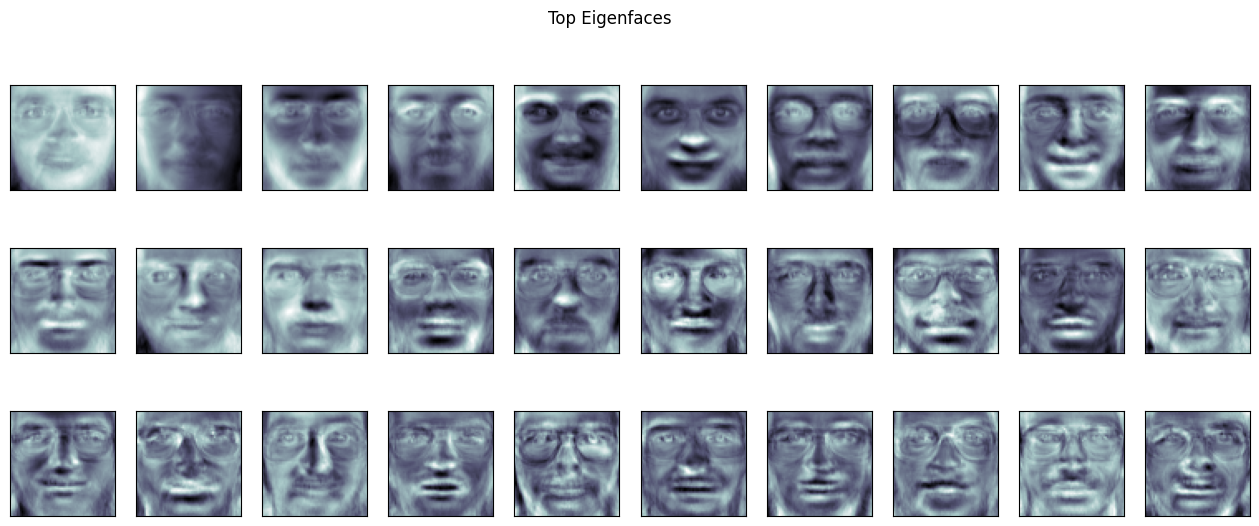

In [16]:
if __name__ == "__main__":
    # Compute and View Eigenfaces
    L,V = recognizer.compute_eigenfaces()
    base_code.plot_eigenfaces(V)


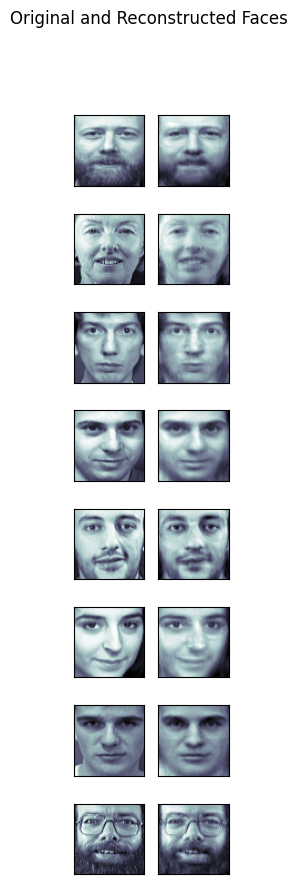

In [17]:
if __name__ == "__main__":
    # Test Transform (compression) of data and Resconstrution
    X_recon = recognizer.compress_and_reconstruct(n_eigenfaces=50)
    base_code.plot_reconstructions(X_train,X_recon)



              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         4
           7       1.00      0.67      0.80         3
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         3
          17       1.00      1.00      1.00         6
          19       1.00      1.00      1.00         4
          20       1.00    

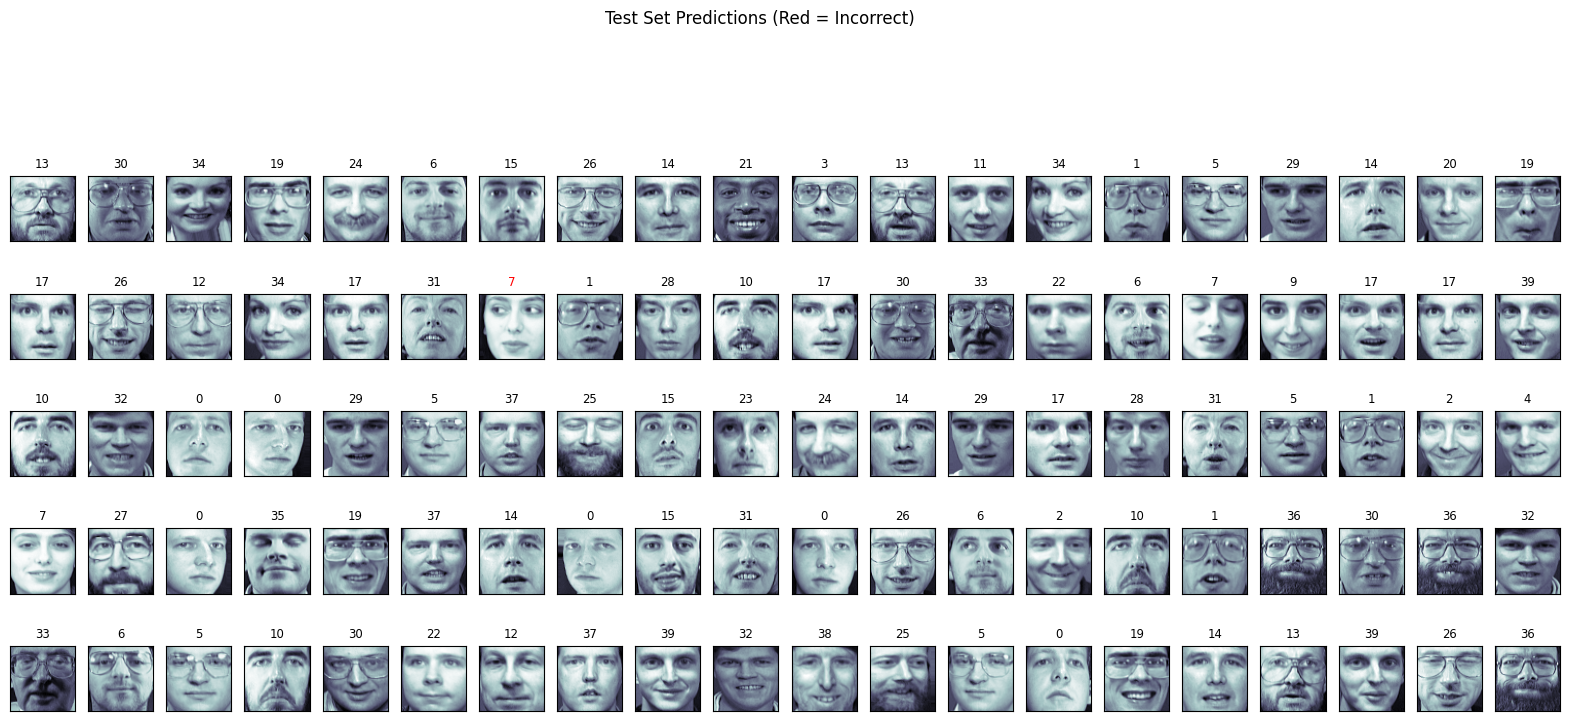

In [18]:
if __name__ == "__main__":
    # Train and test classifier (can vary number of eigenfaces)
    recognizer.train_classifier(method='svm', n_eigenfaces=50)
    y_pred = recognizer.test_classifier(n_eigenfaces=50)

    # Obtain Classification Report and
    print(classification_report(y_test, y_pred))

    base_code.plot_test_examples(X_test,y_test, y_pred)
